In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [33]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442400146024_engineered.csv')
# df
# df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
# df.drop('READ_DATE_day', axis=1, inplace=True)
df

,READ_DATE,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss,KWH_EXP_MA,KWH_EXP_ES,trend_ma,cycle_ma
0,2019-01-01,0.000000,25.7,24.8,30.2,44.0,6.4,1008.9,25.7,96.0,12.9,7.5,2.684343,-1.168433,32.042074,-29.357731
1,2019-01-02,0.076469,26.0,24.1,29.2,21.0,5.4,1009.2,25.9,90.0,42.7,6.7,2.684343,1.005092,32.059768,-29.375425
2,2019-01-03,0.310542,24.6,24.0,27.3,340.0,4.1,1010.3,24.9,94.0,0.5,0.1,2.684343,2.338930,32.077463,-29.393119
3,2019-01-04,0.066232,26.2,23.0,29.8,340.0,6.9,1011.4,25.8,88.0,34.6,0.1,2.684343,0.990091,32.095157,-29.410814
4,2019-01-05,1.070875,26.9,23.6,30.2,284.0,6.3,1011.7,26.7,88.0,2.1,3.2,2.684343,-1.912743,32.112851,-29.428508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,2024-05-27,39.352355,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4,27.409275,35.937390,51.527743,-24.118469
1974,2024-05-28,36.329893,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2,27.614475,39.330228,51.530714,-23.916239
1975,2024-05-29,43.653419,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7,28.506060,36.394131,51.533685,-23.027625
1976,2024-05-30,40.912175,29.7,25.0,35.0,106.0,7.8,1009.7,29.6,73.0,0.0,10.6,29.064772,37.934346,51.536656,-22.471883


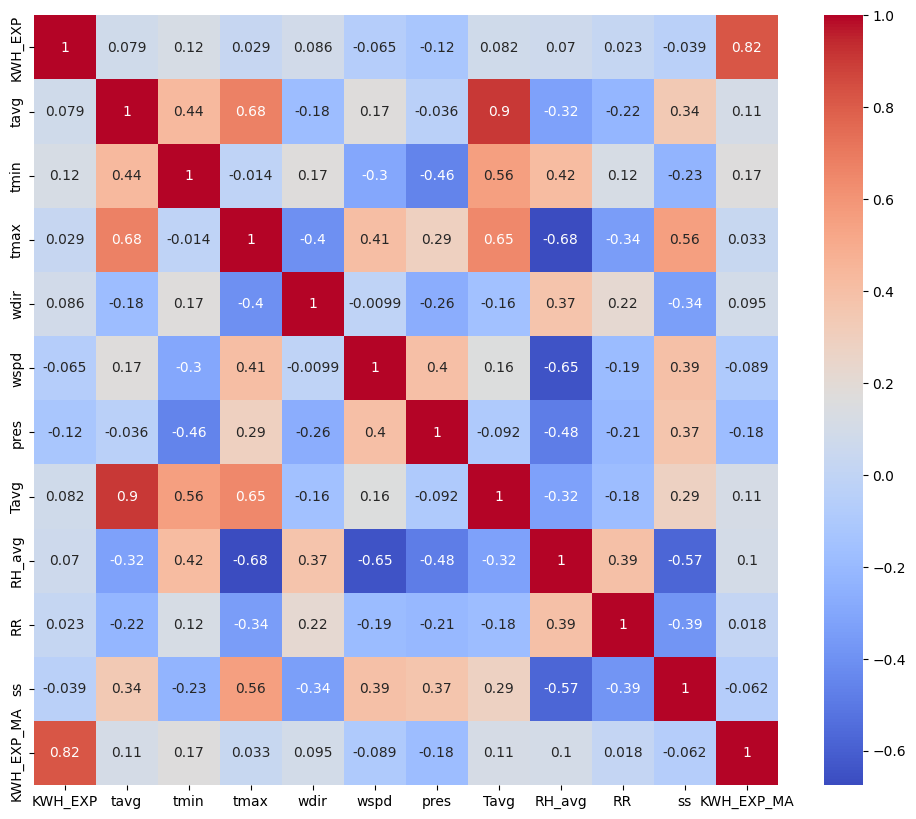

In [34]:
# correlation plot
corr = df.copy()
corr.drop(['READ_DATE', 'KWH_EXP_ES', 'trend_ma', 'cycle_ma'], axis=1, inplace=True)
corr = corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [35]:
df.columns

Index(['READ_DATE', 'KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres',
       'Tavg', 'RH_avg', 'RR', 'ss', 'KWH_EXP_MA', 'KWH_EXP_ES', 'trend_ma',
       'cycle_ma'],
      dtype='object')

In [36]:
df.set_index('READ_DATE', inplace=True)

df.drop(['KWH_EXP', 'KWH_EXP_ES', 'trend_ma', 'cycle_ma'], axis=1, inplace=True)
df.columns

Index(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR',
       'ss', 'KWH_EXP_MA'],
      dtype='object')

In [37]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE
2019-01-01	11.001903	25.7	24.8	30.2	44.0	6.4	1008.9
2019-01-02	11.422662	26.0	24.1	29.2	21.0	5.4	1009.2
2019-01-03	2.341671	24.6	24.0	27.3	340.0	4.1	1010.3
2019-01-04	4.800008	26.2	23.0	29.8	340.0	6.9	1011.4
2019-01-05	5.752651	26.9	23.6	30.2	284.0	6.3	1011.7
...	...	...	...	...	...	...	...
2024-05-27	2.381903	28.3	24.4	34.0	126.0	9.9	1009.9
2024-05-28	2.412923	28.2	24.1	33.9	125.0	8.0	1009.4
2024-05-29	2.564494	29.0	24.2	33.0	130.0	7.7	1009.1
# 2024-05-30	2.558021	29.7	25.0	35.0	106.0	7.8	1009.7
2024-05-31	2.457463	29.8	25.5	35.2	121.0	9.6	1010.4
"""
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [38]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_MA']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP_MA']])

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_ES']])
# test_scaled_features = feature_scaler.transform(test)
# test_scaled_target = target_scaler.transform(test[['KWH_EXP_ES']])


In [39]:
train_scaled_features

array([[-1.718197  ,  1.02028777, -1.55236723, ...,  0.76411145,
        -0.17024642, -1.78849605],
       [-1.43304526,  0.46910278, -2.13049838, ...,  3.41015117,
        -0.44476392, -1.78849605],
       [-2.76375338,  0.39036207, -3.22894758, ..., -0.33692522,
        -2.70953335, -1.78849605],
       ...,
       [-1.52809584,  0.54784349, -1.55236723, ...,  0.59540422,
        -0.03298767,  1.17526534],
       [-1.52809584,  0.39036207, -3.22894758, ..., -0.06166605,
        -2.05755427,  1.10972005],
       [-0.19738772,  1.02028777, -0.80079673, ...,  2.9750641 ,
        -2.74384803,  1.03711175]])

In [40]:
# # Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]

In [41]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP_MA'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)



Training model with selected features and timesteps = 1
Epoch 33: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


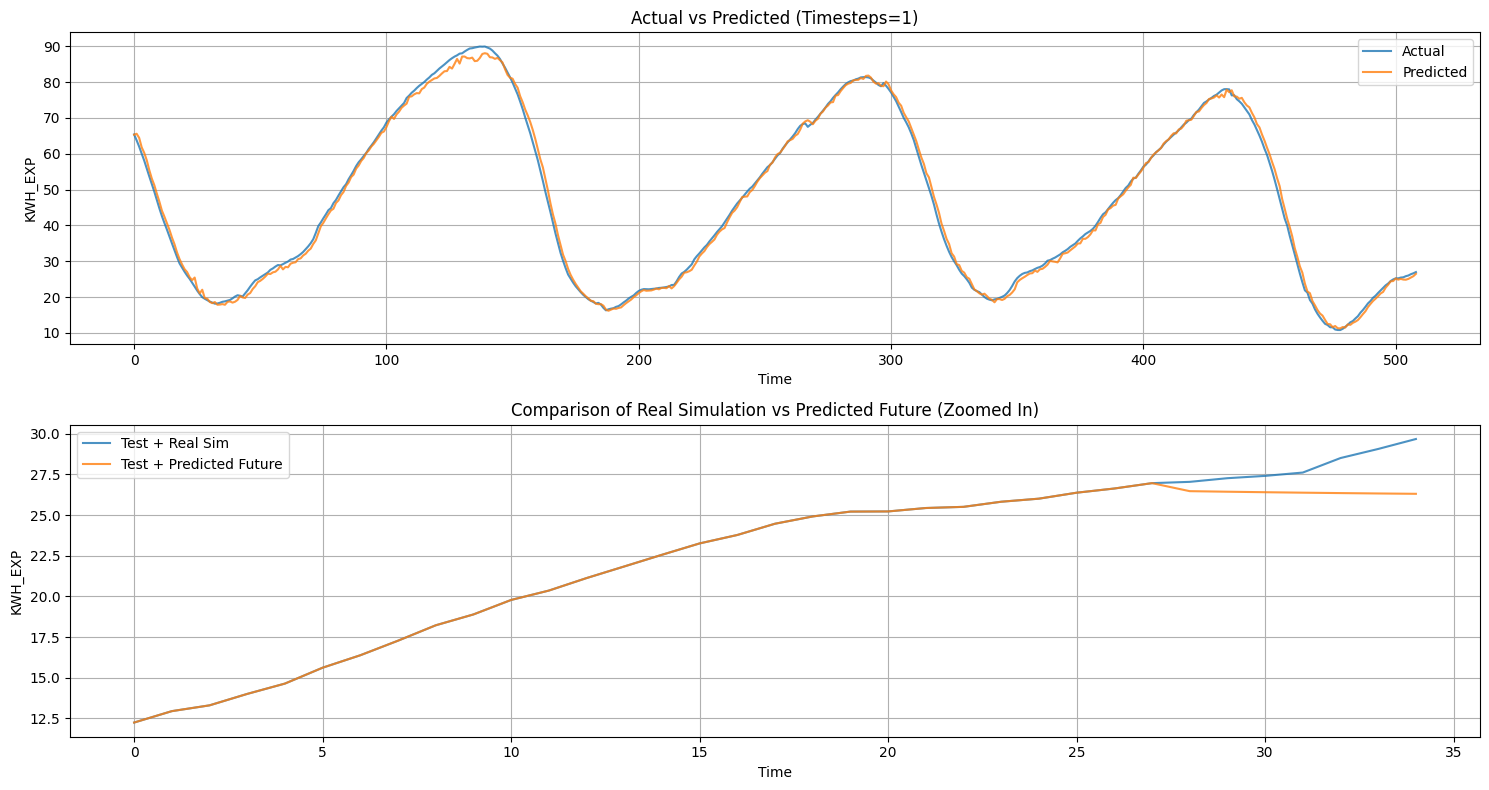


Metrics for timesteps=1:
MSE: 1.7067
R²: 0.9968
MAPE: 0.0271
MAE: 1.0386
Training time for timesteps = 1: 22.50 seconds

Training model with selected features and timesteps = 2
Epoch 26: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Results saved to bilstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


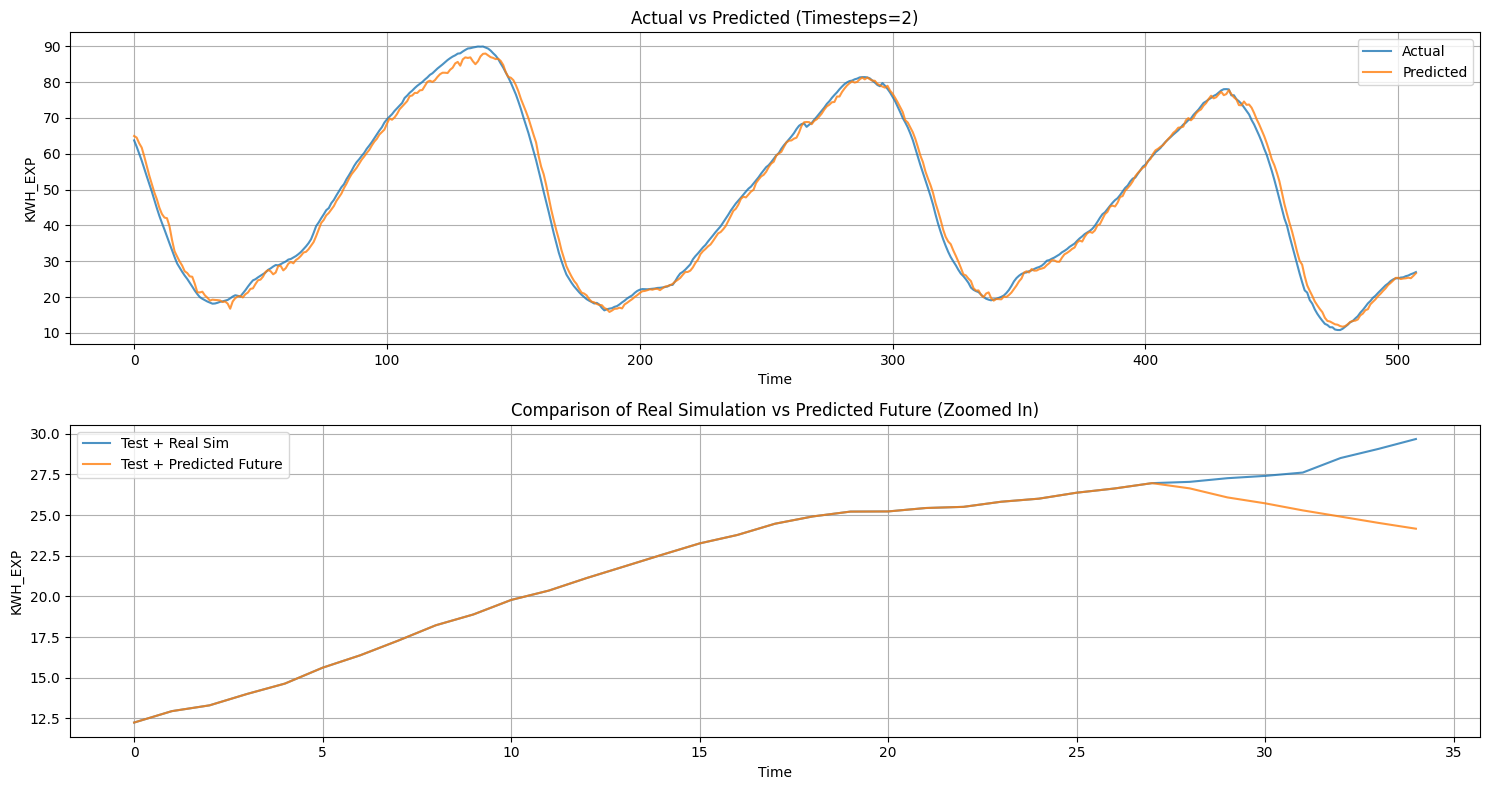


Metrics for timesteps=2:
MSE: 3.2965
R²: 0.9938
MAPE: 0.0383
MAE: 1.4344
Training time for timesteps = 2: 20.00 seconds

Training model with selected features and timesteps = 3
Epoch 23: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


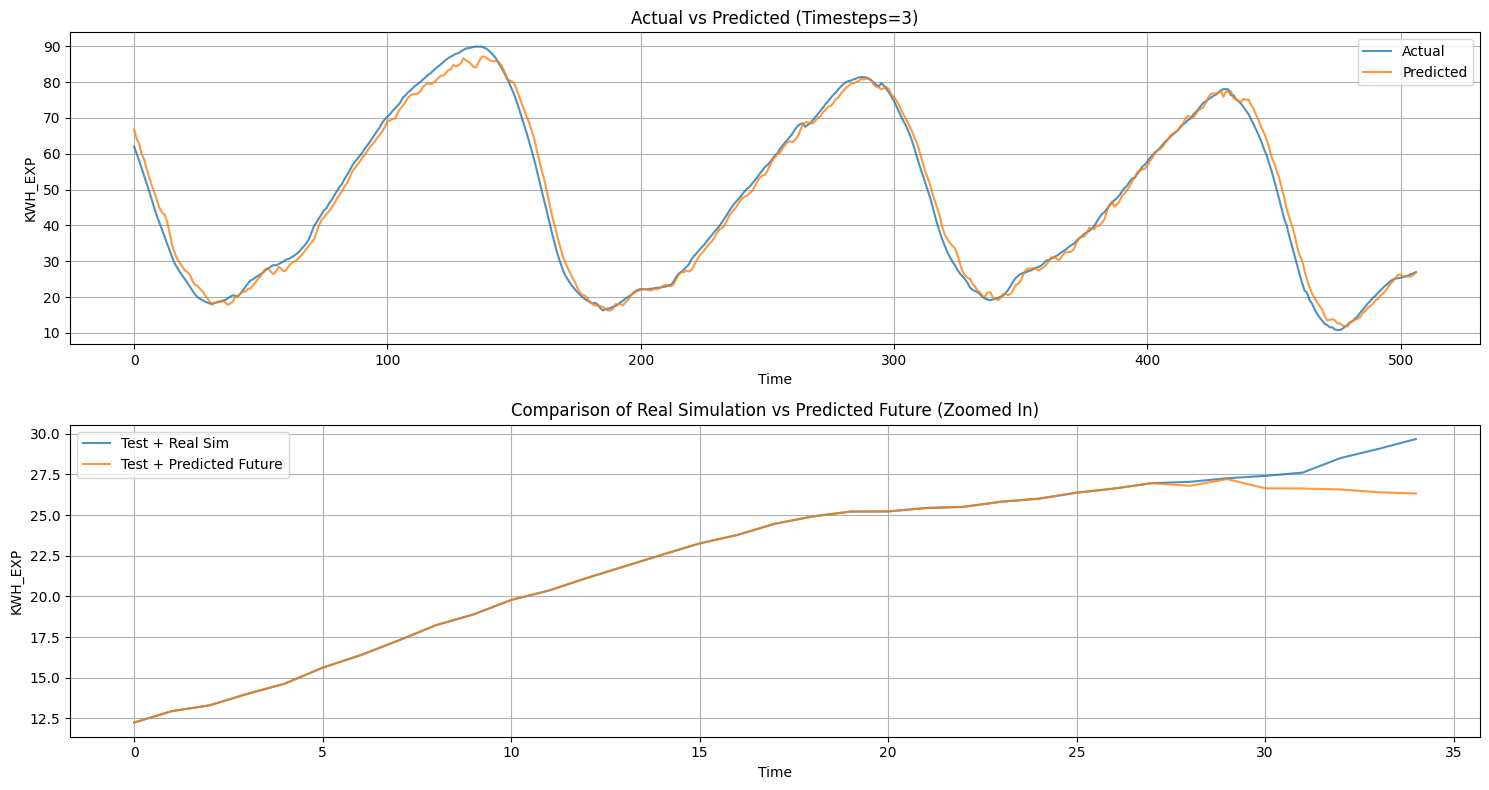


Metrics for timesteps=3:
MSE: 5.7448
R²: 0.9893
MAPE: 0.0491
MAE: 1.8660
Training time for timesteps = 3: 26.28 seconds

Training model with selected features and timesteps = 4
Epoch 19: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
Results saved to bilstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


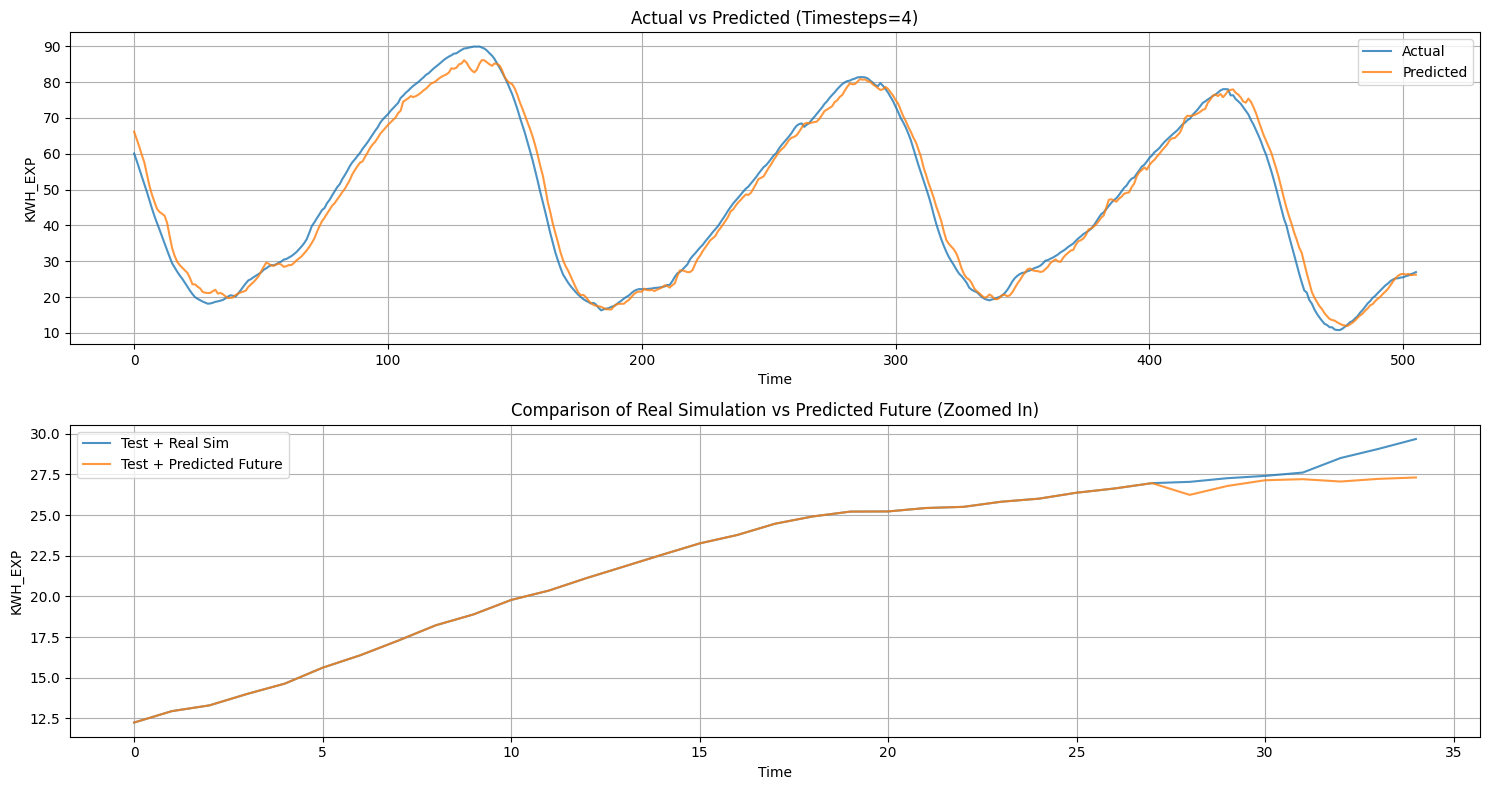


Metrics for timesteps=4:
MSE: 8.4016
R²: 0.9843
MAPE: 0.0604
MAE: 2.3233
Training time for timesteps = 4: 23.31 seconds

Training model with selected features and timesteps = 5
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
Results saved to bilstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


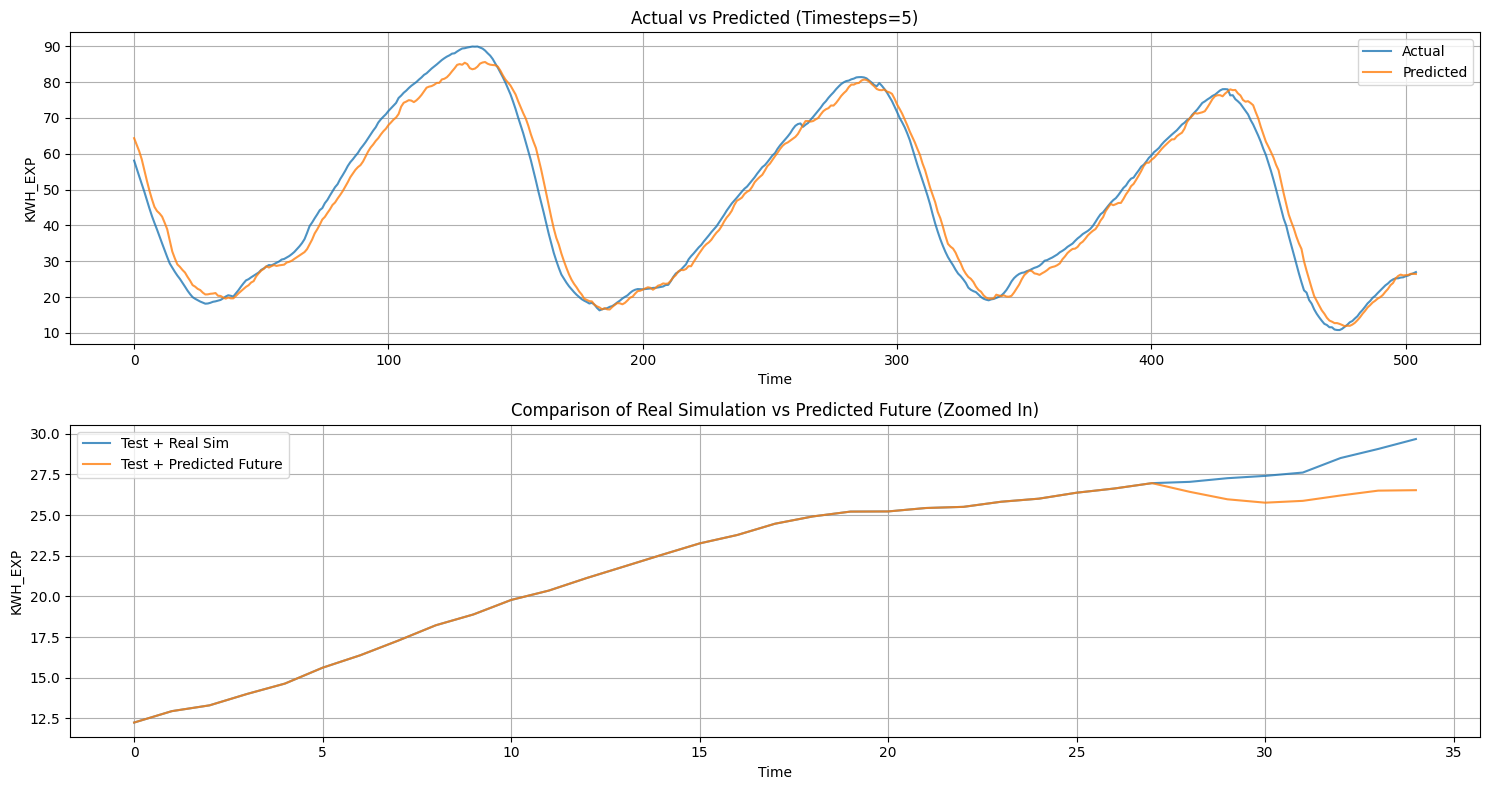


Metrics for timesteps=5:
MSE: 11.2727
R²: 0.9790
MAPE: 0.0687
MAE: 2.6732
Training time for timesteps = 5: 23.70 seconds

Training model with selected features and timesteps = 6
Epoch 11: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Results saved to bilstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


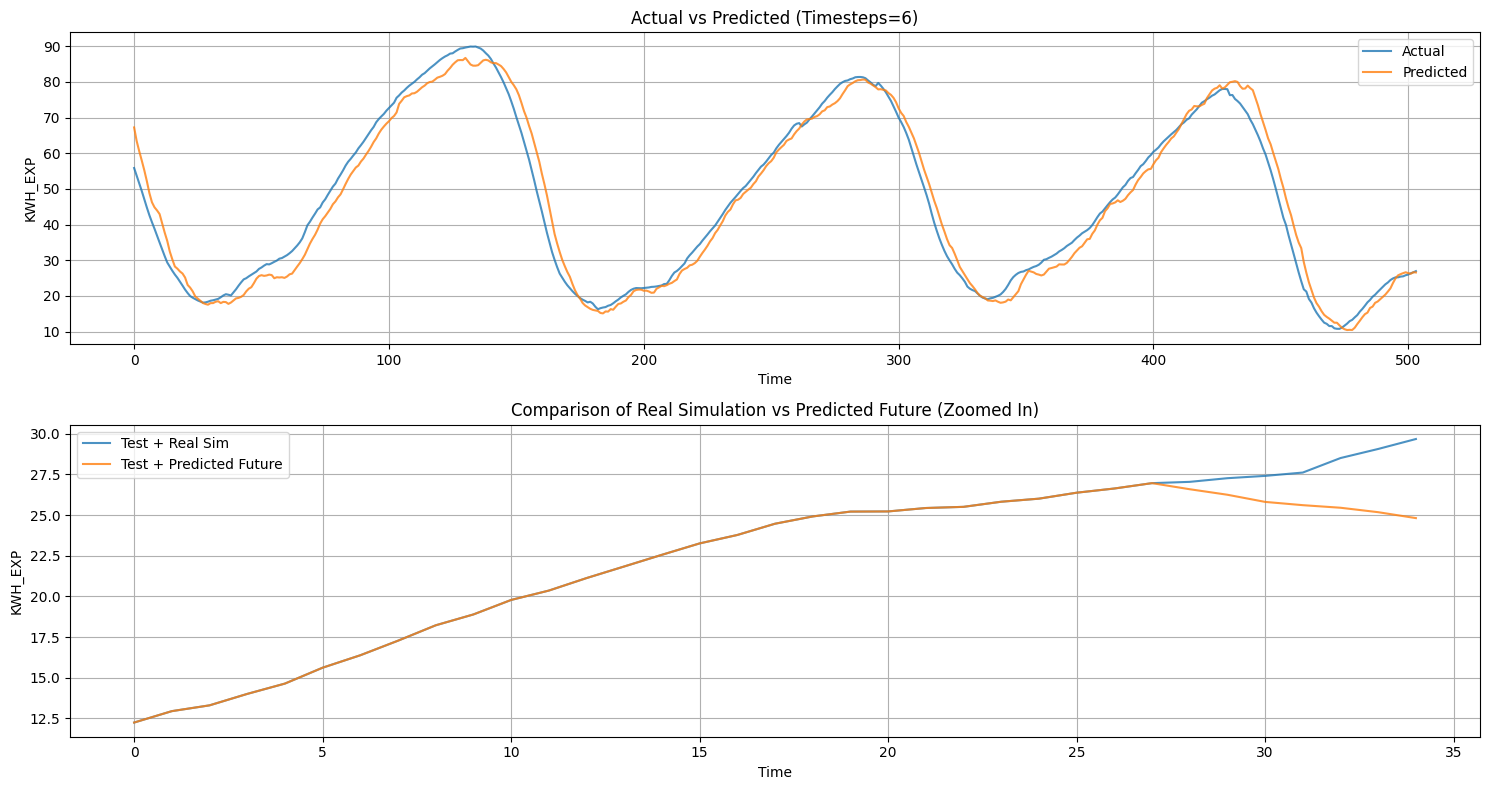


Metrics for timesteps=6:
MSE: 16.4667
R²: 0.9693
MAPE: 0.0857
MAE: 3.2863
Training time for timesteps = 6: 21.49 seconds

Training model with selected features and timesteps = 7
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


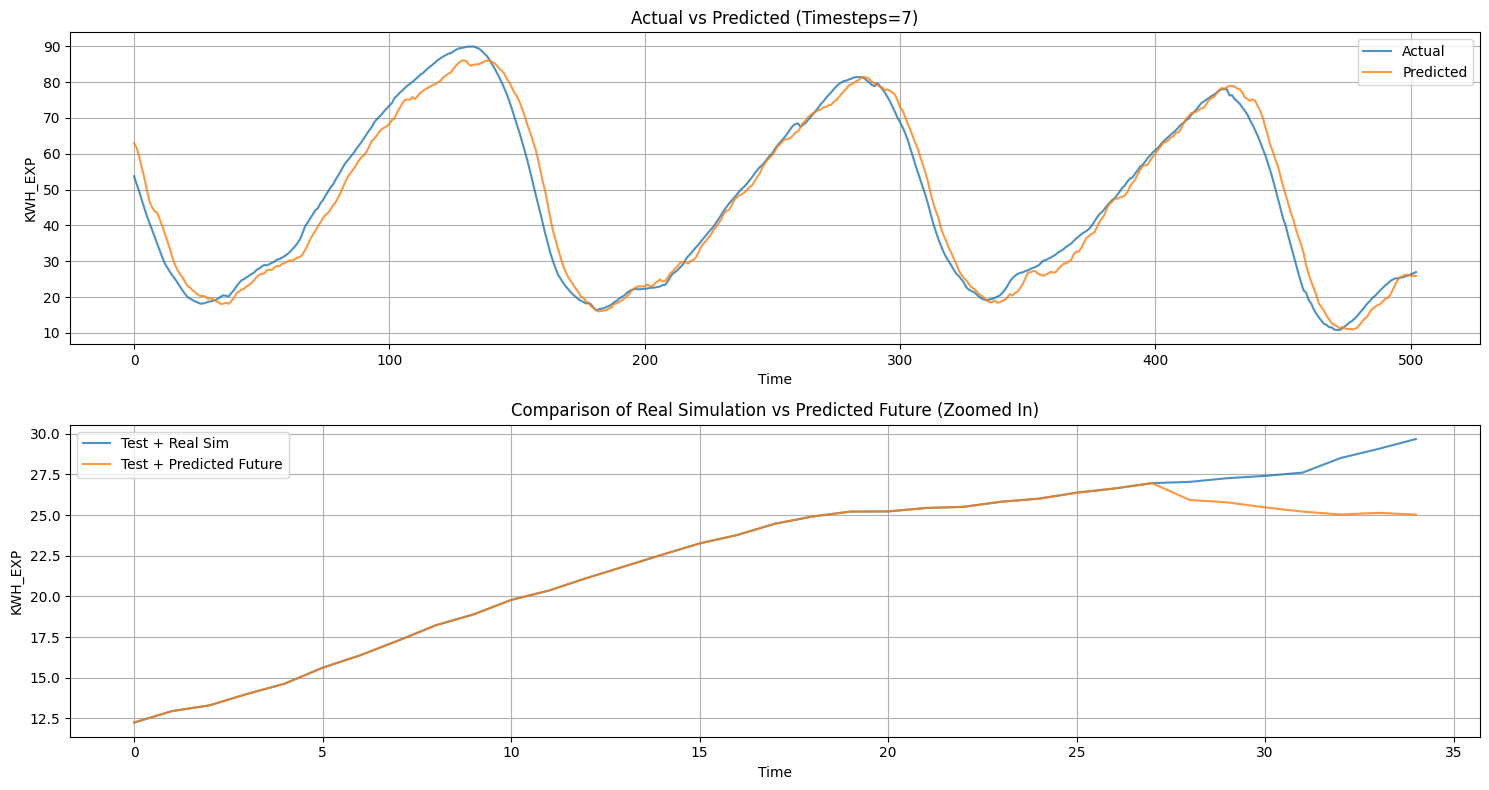


Metrics for timesteps=7:
MSE: 17.9620
R²: 0.9666
MAPE: 0.0868
MAE: 3.2846
Training time for timesteps = 7: 25.80 seconds
Total training execution time: 163.08 seconds


In [42]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:

    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [43]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [44]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 3, 4, 5, 6, 7]


Training model with selected features and timesteps = 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


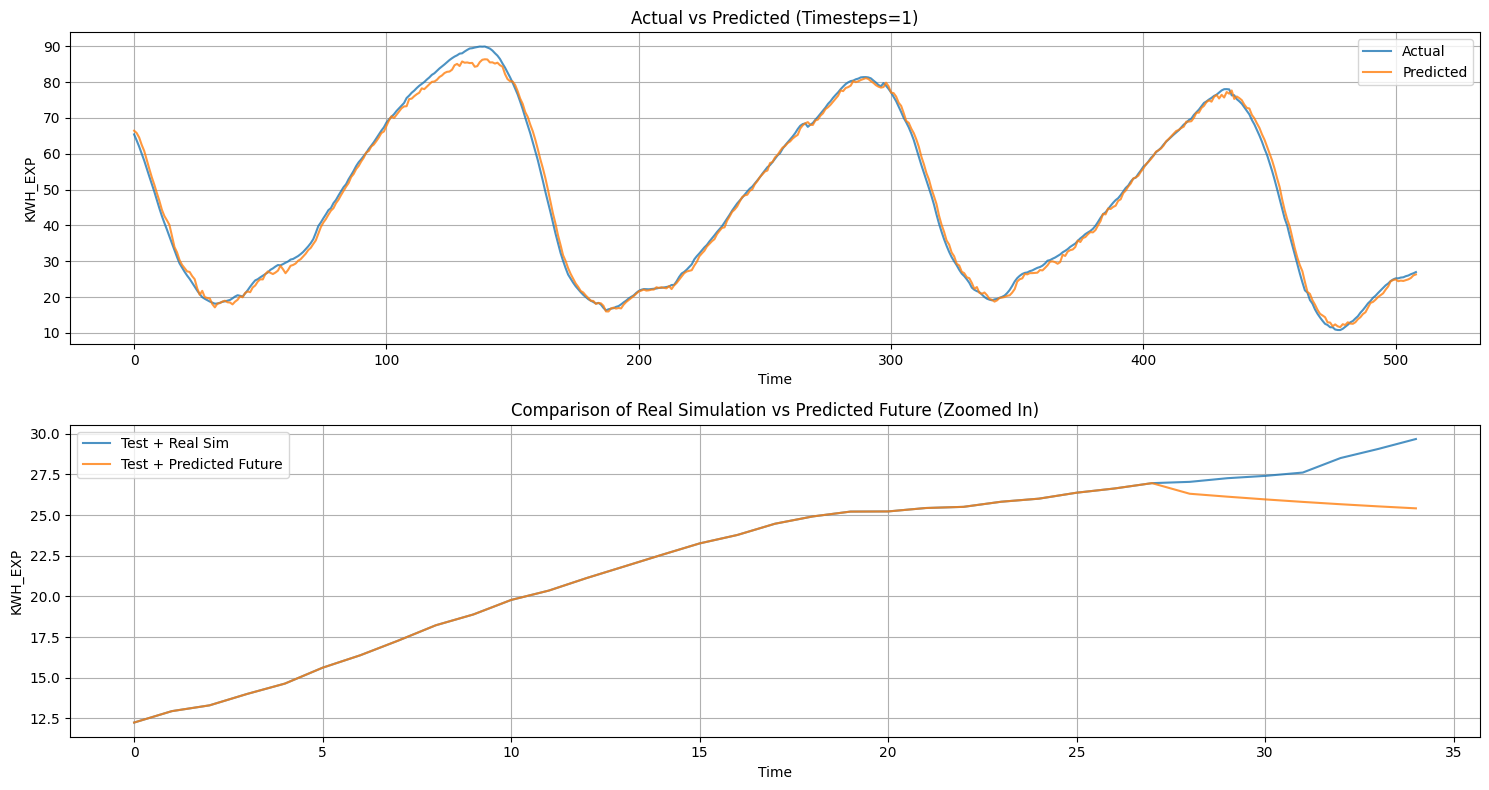


Metrics for timesteps=1:
MSE: 2.1673
R²: 0.9959
MAPE: 0.0296
MAE: 1.1541
Training time for timesteps = 1: 15.49 seconds

Training model with selected features and timesteps = 3
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


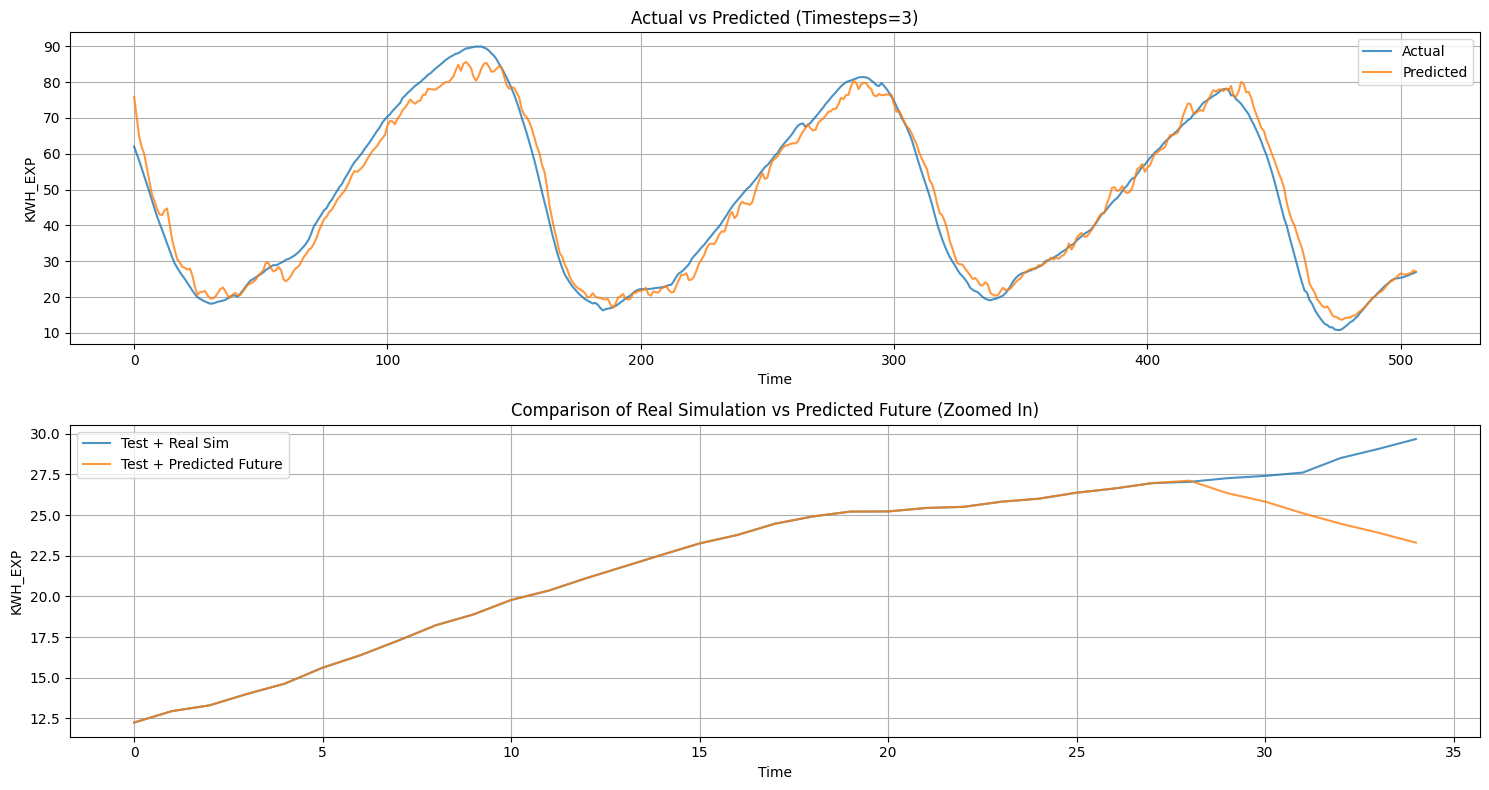


Metrics for timesteps=3:
MSE: 12.1778
R²: 0.9772
MAPE: 0.0723
MAE: 2.7452
Training time for timesteps = 3: 12.57 seconds

Training model with selected features and timesteps = 3
Epoch 17: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


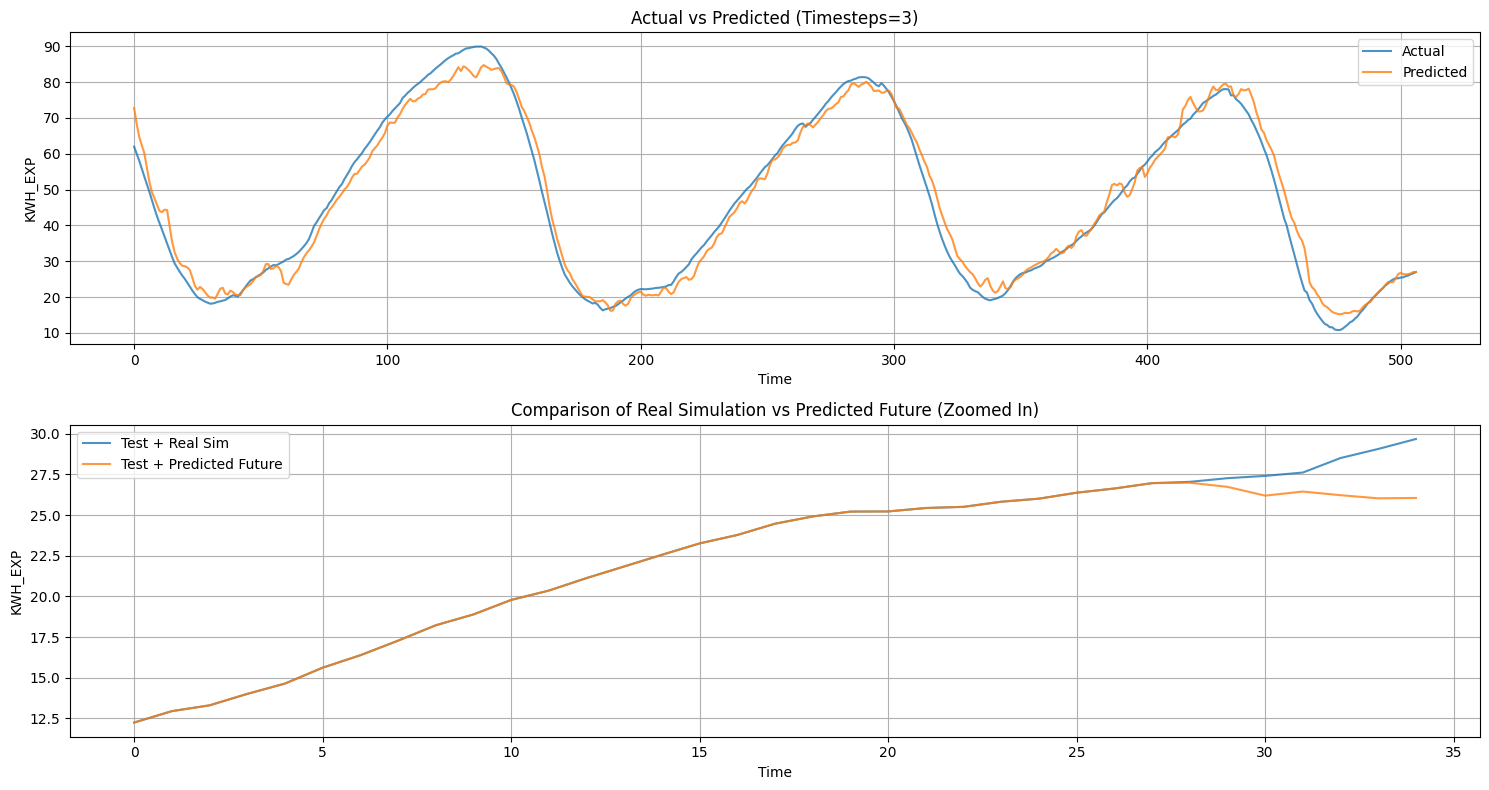


Metrics for timesteps=3:
MSE: 13.1586
R²: 0.9754
MAPE: 0.0798
MAE: 2.9065
Training time for timesteps = 3: 11.89 seconds

Training model with selected features and timesteps = 4
Epoch 15: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Results saved to lstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


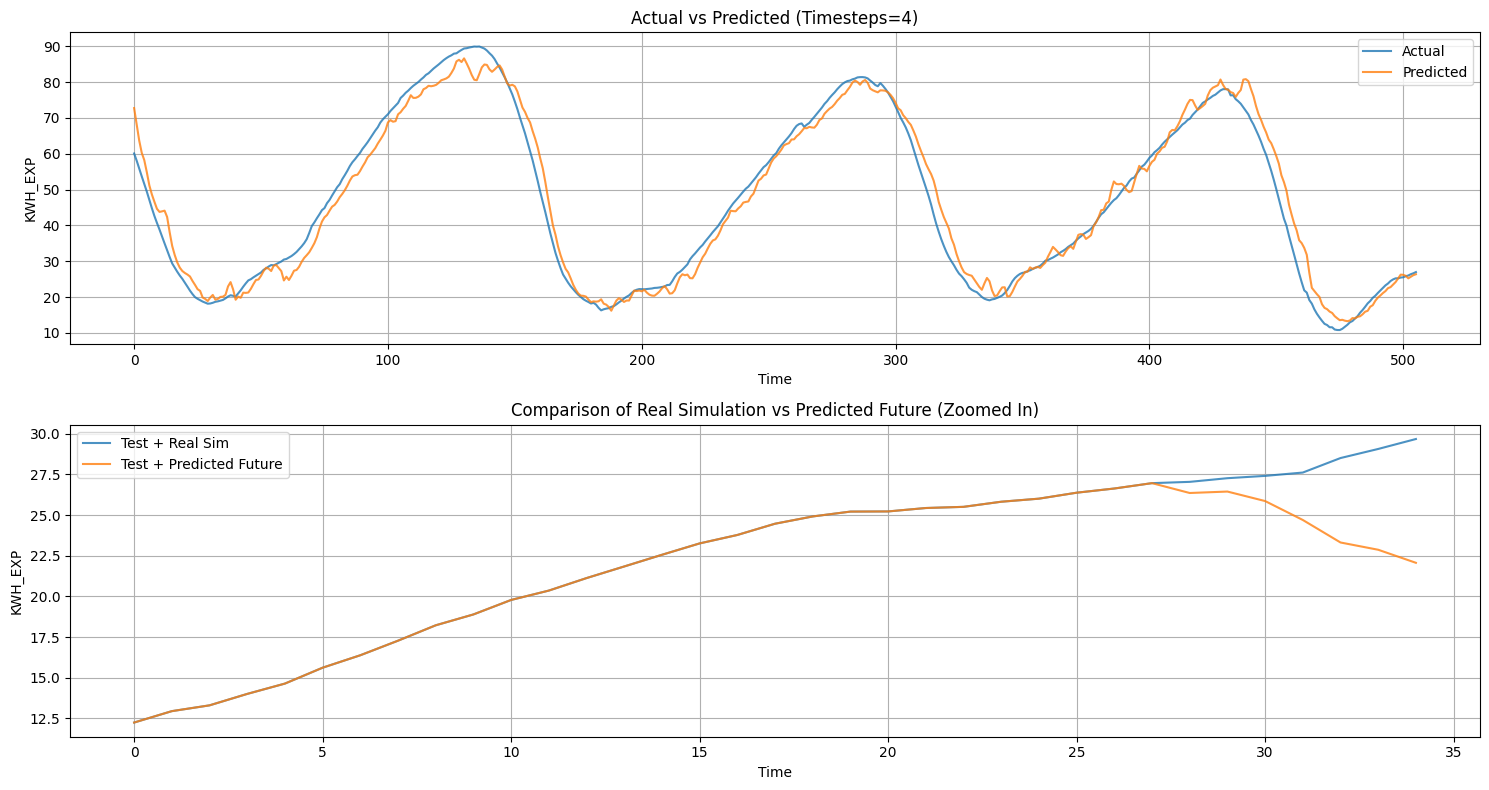


Metrics for timesteps=4:
MSE: 16.3242
R²: 0.9695
MAPE: 0.0836
MAE: 3.1627
Training time for timesteps = 4: 11.67 seconds

Training model with selected features and timesteps = 5
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Results saved to lstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


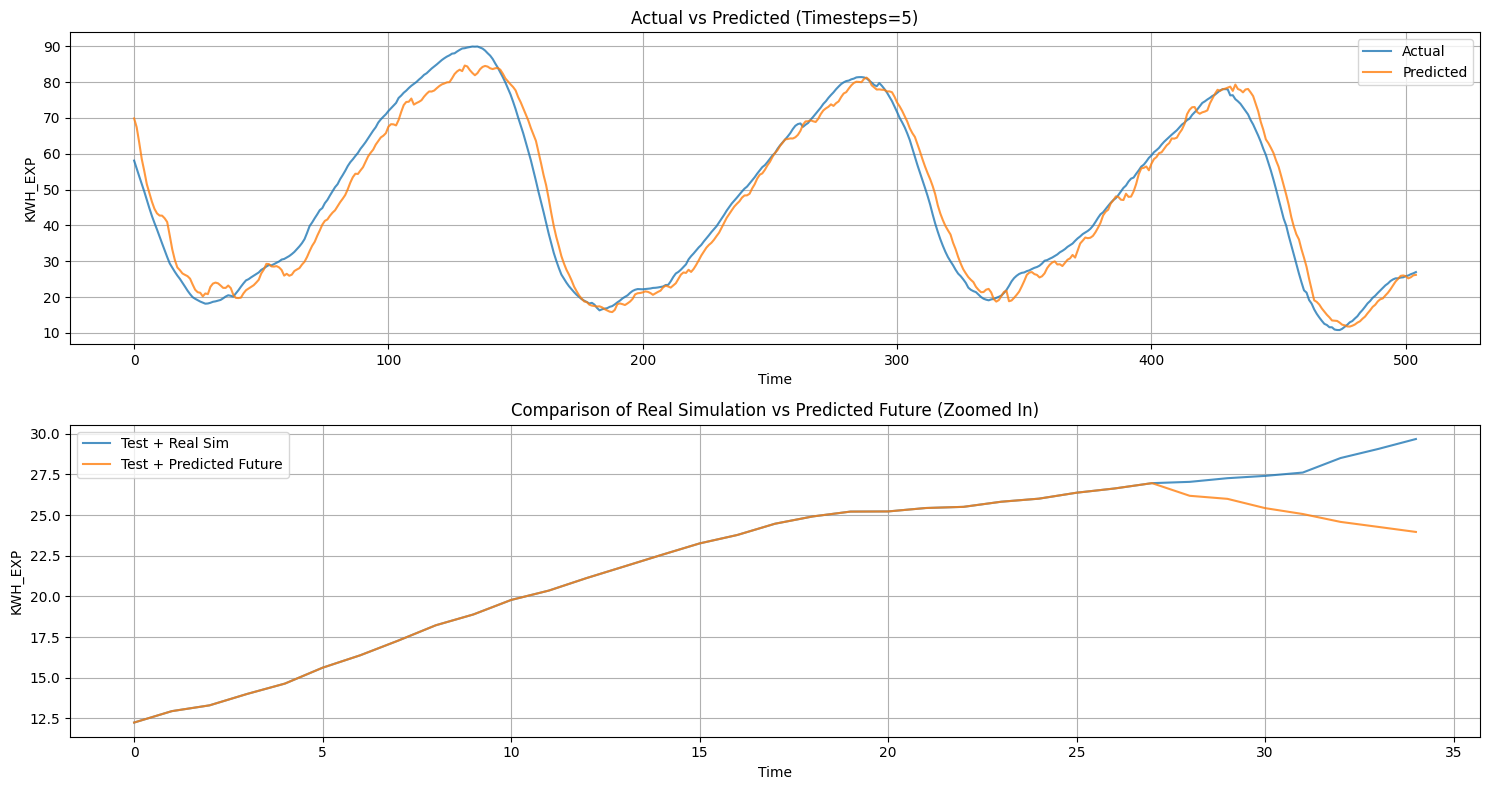


Metrics for timesteps=5:
MSE: 18.3652
R²: 0.9658
MAPE: 0.0902
MAE: 3.4576
Training time for timesteps = 5: 13.45 seconds

Training model with selected features and timesteps = 6
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Results saved to lstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


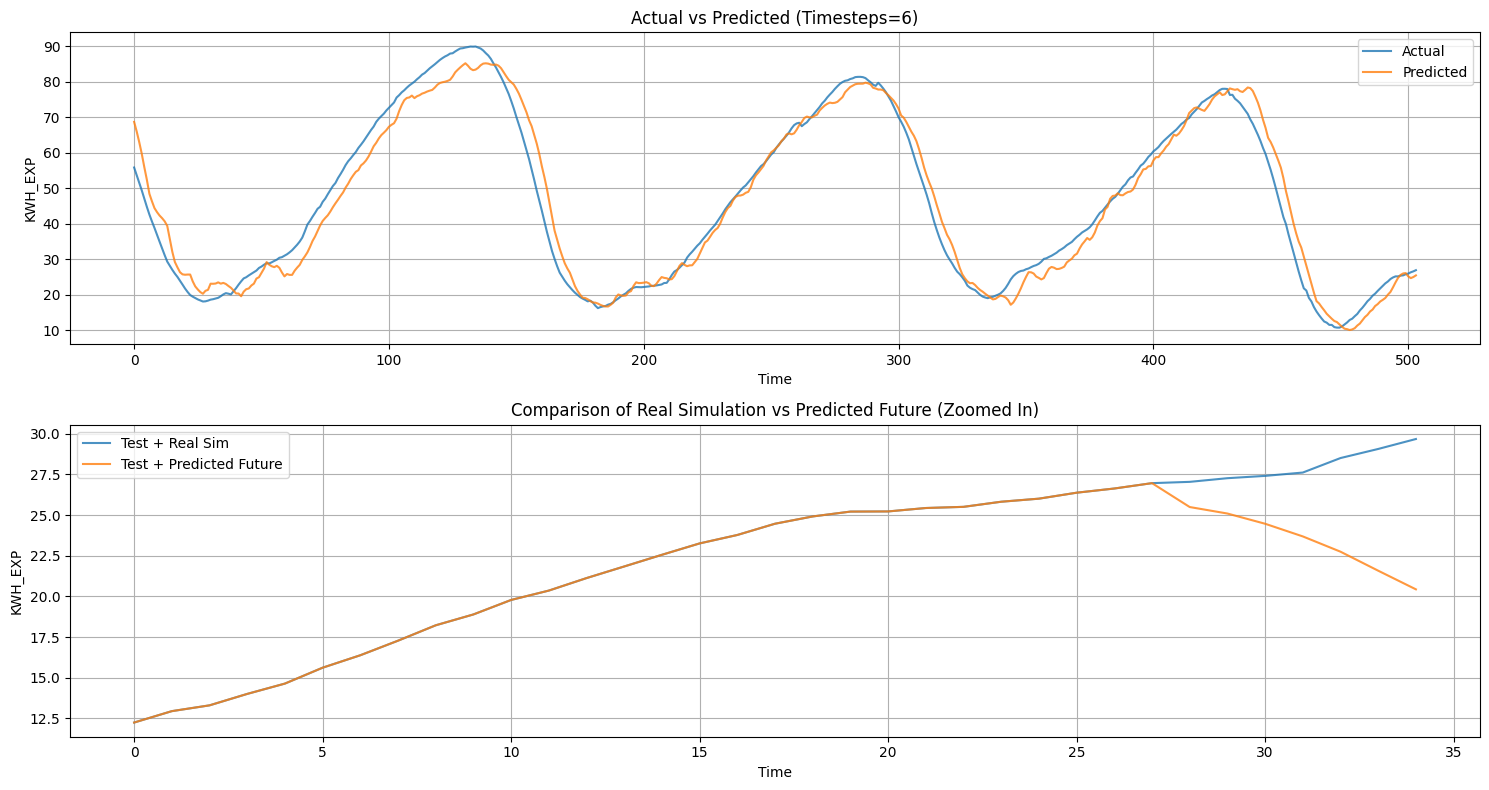


Metrics for timesteps=6:
MSE: 21.7950
R²: 0.9594
MAPE: 0.0968
MAE: 3.6801
Training time for timesteps = 6: 13.55 seconds

Training model with selected features and timesteps = 7
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


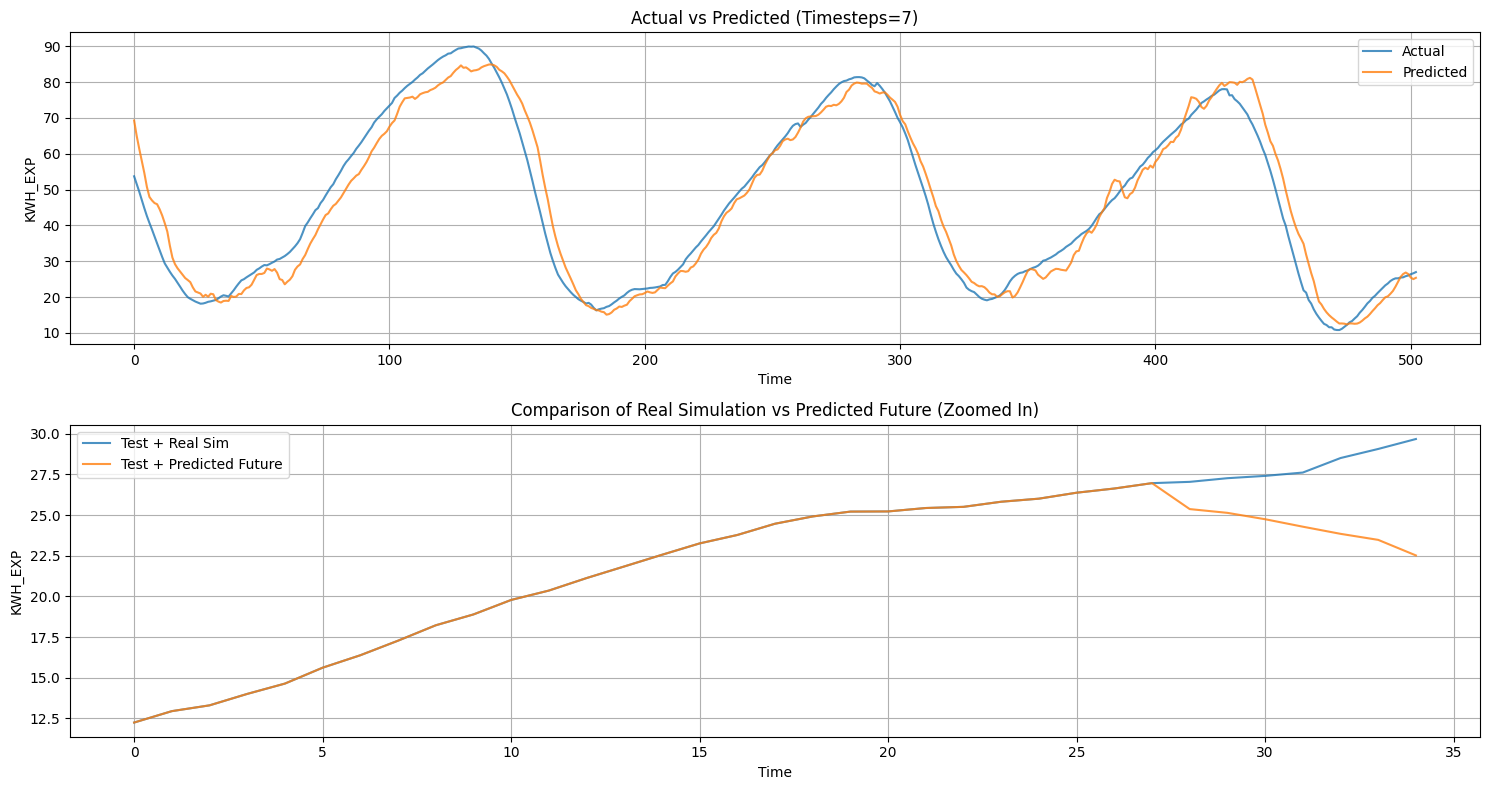


Metrics for timesteps=7:
MSE: 27.8809
R²: 0.9482
MAPE: 0.1103
MAE: 4.1910
Training time for timesteps = 7: 13.56 seconds
Total training execution time: 92.19 seconds


In [45]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")